<h1 align='center' style='color:purple'><b>HR Analytics</b></h1>

**Problem Statement**  
A large company named XYZ, employs, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons -

1. The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
2. A sizeable department has to be maintained, for the purposes of recruiting new talent
3. More often than not, the new employees have to be trained for the job and/or given time to acclimatise themselves to the company
Hence, the management has contracted an HR analytics firm to understand what factors they should focus on, in order to curb attrition. In other words, they want to know what changes they should make to their workplace, in order to get most of their employees to stay. Also, they want to know which of these variables is most important and needs to be addressed right away.

Since you are one of the star analysts at the firm, this project has been given to you.

**Goal of the case study**  
You are required to model the probability of attrition using a Decision trees. The results thus obtained will be used by the management to understand what changes they should make to their workplace, in order to get most of their employees to stay.

# Outline
1. Import & Merge Datasets
2. Missing Value's Imputation
3. Exploratory Data Analysis 
4. Feature Engineering
5. Model Building
6. Model Evaluation

In [1]:
# Import Pandas and NumPy
import numpy as np 
import pandas as pd

# Import Libraries for plotting
import matplotlib.pyplot as plt, seaborn as sns

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Change pandas settings to Display all columns
pd.set_option('display.max_columns',None)

### 1. Import & Merge Datasets

In [2]:
# We will be using 5 Datasets for this project 
# General Data
general_data = pd.read_csv('general_data.csv')

# Survey Data
manager_survey_data = pd.read_csv('manager_survey_data.csv')
employee_survey_data = pd.read_csv('employee_survey_data.csv')

# Office Entry/Exit Timings
in_time = pd.read_csv('in_time.csv')
out_time = pd.read_csv('out_time.csv')

# Import Data Dictionary - which contains details about each variables present in all 5 datasets
data_dictionary = pd.read_excel('data_dictionary.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'general_data.csv'

### Lets have a look at each datasets

#### General Data

In [ ]:
print('Shape of general_data :',general_data.shape)
general_data.head()

This Dataset contains employee general work related details.

#### Manager Survey Data

In [ ]:
print('Shape of manager_survey_data :',manager_survey_data.shape)
manager_survey_data.head()

This Dataset contains the details of survey given by the manager of every employee.

#### Employee Survey Data

In [ ]:
print('Shape of employee_survey_data :',employee_survey_data.shape)
employee_survey_data.head()

This Dataset contains the details of survey given by employee.

#### In_time Data

In [ ]:
print('Shape of in_time :',in_time.shape)
in_time.head()

This dataset contains the office start/entry time for the entire year 2015.

#### Out_time Data

In [ ]:
print('Shape of out_time :',out_time.shape)
out_time.head()

This dataset contains the office end/exit time for the entire year 2015.

#### View the Data Dictionary, which contains information about each variables present in all 5 datasets.

In [ ]:
data_dictionary.replace(np.nan," ")

#### Using in_time and out_time, find the mean working hour of each employee

Fill Missing values in in_time & out_time.

In [ ]:
in_time.fillna(0, inplace=True)
out_time.fillna(0, inplace=True)

Convert all columns (except unnamed:0 which is employee id) to Datetime format using pandas.

In [ ]:
in_time.iloc[:, 1:] = in_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')  #coerce : in case of error during conversion, place NaN or NaT.
out_time.iloc[:, 1:] = out_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

Join in_time and out_time into a single df total_time using append.

In [ ]:
total_time=in_time.append(out_time)

Find the difference between the out_time and in_time using diff.

In [ ]:
total_time=total_time.diff(periods=4410)      # diff find the difference of two values in a df. 
total_time=total_time.iloc[4410:]             # As the first 4410 value are nan, the diff is availble from 4410 till 8820.

# reset the index as now index starts from 4410
total_time.reset_index(inplace=True)
total_time.head()

A few columns have 0 value. It means that office was closed on that particular day.

In [ ]:
# remove these columns to calculate mean time (remember that index is employee id, so, later we need to add it again)
total_time.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)
total_time.head()

In [ ]:
# remove all 0 columns which represent holidays ()
total_time.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05','2015-05-01','2015-07-17','2015-09-17',
                 '2015-10-02','2015-11-09','2015-11-10','2015-11-11','2015-12-25'], axis = 1,inplace=True) 

In [ ]:
# Find mean of each row and save it to a 'mean_time' column
total_time['mean_time']=total_time.mean(axis=1)

In [ ]:
# Lets have a look at the total_time df
total_time

In [ ]:
# Lets have a look at a time record
total_time.iloc[0,0]

We can compute the total hours by converting this to string and splitting it by ' ', then by again splitting it by ' ' we will get hour, minutes and seconds. Add hour, minutes/60 and second/3600 to get total hours.

In [ ]:
# Convert mean time to hours - 
total_time.mean_time = total_time.mean_time.apply(lambda x : int(str(x).split(' ')[2].split(':')[0]) + int((str(x).split(' ')[2].split(':')[1]))/60
                           + float((str(x).split(' ')[2].split(':')[2]))/3600)

In [ ]:
# Againg add a columns for employee id - since id was from 0 to 4410, we can get it just by resetting the index
total_time.reset_index(inplace=True)

# Lets have a look at the total_time dataframe
total_time.head()

In [ ]:
# rename index as EmployeeID (as it is the columns name in general_data) for convienience while merging datasets
total_time = total_time.rename(columns={'index': 'EmployeeID'})
total_time.head()

In [ ]:
# Since we only need employee id and mean working time of employee, remove all other columns
total_time = total_time.drop((total_time.columns[1:-1]), axis = 1)

#### Final total_time df with employee_id and mean time

In [ ]:
total_time.head()

#### Merge all 5 dataframers, two at a time using merge

In [ ]:
# First merger general_data and manager_survey_data and save it in df dataframe
df = pd.merge(general_data, manager_survey_data, on='EmployeeID', how='inner')

# Merge employee_survey_data to df
df = pd.merge(df, employee_survey_data, on='EmployeeID', how='inner')

# Finally merge mean working time of employees to df
df = pd.merge(df, total_time, on='EmployeeID', how='inner')
df.head()

#### Let's check column data types

In [ ]:
df.info()

#### Let's Check the distribution of numerical columns

In [ ]:
df.describe()

'EmployeeCount' & 'StandardHours' have 0 standard deviation (std) which means same values is present in each record.

#### Let's check if a object data type (Categorical) column also has single unique value

In [ ]:
# Select categorical columns
obj_cols = df.select_dtypes(include=['object']).columns

# Count the number of unique values in each of the column names saved in obj_cols & print column name if only 1 unique value
for i in obj_cols:
    # calculate unique values 
    unique_values = len(df[i].value_counts())
    if unique_values == 1:
        print(i, 'column has only 1 unique value')

#### Drop 'EmployeeCount', 'StandardHours', 'Over18' (Since they have single unique value, they do not contribute any information during model training)

In [ ]:
df.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 1, inplace = True)

## 2. Missing Value's Imputation

#### Check for missing Values

In [ ]:
df.isnull().sum()

Missng values are present in 5 columns/input features.

In [ ]:
plt.figure(figsize = (18,11))
sns.heatmap(df.isnull(), cmap="Blues", yticklabels=False, cbar = False)
plt.xticks(rotation=25)
plt.xlabel('Features', fontsize = 12)
plt.title('Missing Values', fontsize = 16)
plt.show()

We see that in 5 columns there are a few missing values. Altough, there are quiet a few missing values.

#### Missing values Imputation for NumCompaniesWorked Column

In [ ]:
# Check the distribution of MiNumCompaniesWorked

# Plot NumComapniesworked Countplot
plt.figure(figsize=(18,5))
ax = sns.countplot(x='NumCompaniesWorked',data=df, palette='Set2')

# Set xticks name
ax.set(xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=[0,1,2,3,4,5,6,7,8,9])

# set title, xlabel, ylabel
plt.title('Distribution of Number of companies employees worked in', fontsize=14)
ax.set_xlabel('NumCompaniesWorked',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.show()

Fill missing values in NumCompaniesWorked with mode i.e. 1


In [ ]:
df['NumCompaniesWorked'].fillna(1.0,inplace = True)

#### Missing values Imputation for EnvironmentalSatisfaction Column

In [ ]:
# Check the Distribution of EnvironmentalSatisfaction

# plot countplot of values in EnvironmentalSatisfaction
plt.figure(figsize=(18,5))
ax = sns.countplot(x='EnvironmentSatisfaction',data=df, palette='Set2')

# set x ticks name by refering to data dictionary
ax.set(xticks=[0,1,2,3], xticklabels=['Low','Medium','High','Very High'])

# set title, xlabel, ylabel
plt.title('Distribution of employees Environmental Satisfaction', fontsize=14)
ax.set_xlabel('Environmental Satisfaction',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.show()

3.0 and 4.0 which means high and very high satisfaction occur most of the time.

In [ ]:
# Since there are two values with same count, lets find the median value of EnvironmentalSatisfaction
print('For EnvironmentSatisfaction median :', df.EnvironmentSatisfaction.median())

Lets replace the missing values by 3.0 which means High EnvironmentSatisfaction

In [ ]:
df['EnvironmentSatisfaction'].fillna(3.0,inplace = True)

#### Missing values Imputation for JobSatisfaction Column

In [ ]:
# Check the distribution of JobSatisfaction

# plot countplot of values in JobDistribution
plt.figure(figsize=(18,5))
ax = sns.countplot(x='JobSatisfaction',data=df, palette='Set2')

# set xticks names
ax.set(xticks=[0,1,2,3], xticklabels=['Low','Medium','High','Very High'])

# set title, xlabel, ylabel
plt.title('Distribution of employees Job Satisfaction', fontsize=14)
ax.set_xlabel('Job Satisfaction',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.show()

Again, 3.0 and 4.0 which means high and very high satisfaction occur most of the time.
Lets find the median

In [ ]:
df.JobSatisfaction.median()

Replace missing values in JobSatisfaction with the mode (3.0)

In [ ]:
df['JobSatisfaction'].fillna(3.0,inplace = True)

#### Missing values imputation for WorkLifeBalance Column

In [ ]:
# Check the distribution of WorkLifeBalance

# plot countplot of values in WorkLifeBalance
plt.figure(figsize=(18,5))
ax = sns.countplot(x='WorkLifeBalance',data=df, palette='Set2')
ax.set(xticks=[0,1,2,3], xticklabels=['Bad','Good','Better','Best'])

# set title, xlabel, ylabel
plt.title('Distribution of employees work-Life Balance', fontsize=14)
ax.set_xlabel('Work-Life Balance',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.show()

3.0 which means high WorkLifeBalance occurs most of the time.

Lets replace missing values in WorkLifeBalance with the mode (3.0)

In [ ]:
df['WorkLifeBalance'].fillna(3.0,inplace = True)

#### Missing values Imputation for TotalWorkingYears Column

In [ ]:
# Check the distribution of TotalWorkingYears

# plot countplot of values in TotalWorkingYears
plt.figure(figsize = (18,6))
sns.countplot(x='TotalWorkingYears',data=df, palette='Set2')

# set title, xlabel, ylabel
plt.title('Distribution of employees Total Working Years', fontsize=14)
ax.set_xlabel('Total Working Years',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.show()

In [ ]:
print('Median of Total Working Year :',df.TotalWorkingYears.median())

Lets Fill the missing values in Total Working Years with 10.0

In [ ]:
df['TotalWorkingYears'].fillna(10.0,inplace = True)

### Check if all missing values have been imputed

In [ ]:
print('Total Number of Missing Values remaining :',df.isnull().sum().sum())

AllMissing Values Imputed!

## 3. Exploratory Data Analysis

#### Create a copy of df for performing EDA as we may change a few features while plotting

In [ ]:
df_eda = df.copy()

#### Let's go through each input feature to gain some insights about Employee Attrition

In [ ]:
# Age - Lets create buckets/bins of 10 years
df_eda.Age = pd.cut(df.Age, range(10, 70, 10)) # Create buckets of 10 years

We use pandas.cut to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Here, cut is used to could convert Age's to groups of age ranges.

In [ ]:
def make_plot(feature_name, x_ticks = 'not_needed'):
    """This function is used to generate a countplot for the passed input feature present
    in df_eda dataframe. Appropriate plot title, xlabel, ylabel, lengend are also added.
    The last part of this function also places a percentage value over each bar of
    generated countplot.

    Args:
        feature_name: the feature name in string format.
        x_ticks: default value is 'not_needed'. If you want to customize xticks then pass
                 a list containing new xticks.

    """
    # Initialize a figure
    plt.figure(figsize = (18,7))
    
    # Generate a countplot for the passed feature_name
    ax = sns.countplot(x=feature_name, hue='Attrition', data=df_eda, palette='Set2')
    
    # Check if custom x_tick is needed or not
    if x_ticks != 'not_needed':
        # Generate index of xticks
        ticks_index = [i for i in range(len(x_ticks))]
        
        # set new xticks by passing ticks_index and custom xtick labels 
        ax.set(xticks=ticks_index, xticklabels=x_ticks)
        
    # set title, xlabel, ylabel, legend
    plt.xlabel(feature_name,fontsize  = 14)
    plt.ylabel('Employee Count',fontsize  = 14)
    plt.title('{} vs Attrition'.format(feature_name), fontsize = 18)
    plt.legend(fontsize = 14)

    # From axis.patches get bar lengths
    get_bars = ax.patches
    half_bar_length = int(len(get_bars)/2)
    bar_left = get_bars[:half_bar_length]
    bar_right = get_bars[half_bar_length:]
    
    # Place %employees on top of each bar
    for L, R in zip(bar_left, bar_right):
        left_height = L.get_height()
        right_height = R.get_height()
        length_total = left_height + right_height

        # place calculated employee percentage on top of each bar
        ax.text(L.get_x() + L.get_width()/2., left_height + 30, '{0:.0%}'.format(left_height/length_total), ha="center")
        ax.text(R.get_x() + R.get_width()/2., right_height + 30, '{0:.0%}'.format(right_height/length_total), ha="center")

In [ ]:
pd.crosstab(df_eda['Age'],df_eda['Attrition'])

In [ ]:
# Age

# using make_plot function, plot a Countplot of Employee's Age by Attrition 
make_plot('Age')

apply chi square test for checking significance between catagorical

 - Employee Attrition % Reduces with Age. So, company should focus on retaining young employees. 
 - 23% of Employees in Age range 20-30 leave the comapny, maybe in search some better jobs
 - 57% attrition was observed in age range 10-20. But, this may not be a problem as there are just a few employees in this age range. Also most of the employees in this age range must be interns.

In [ ]:
# BusinessTravel

# using make_plot function, plot a Countplot of Employee's BusinessTravel by Attrition 
make_plot('BusinessTravel')

 - We can observe a clear trend of Employees who Travel Frequently tend to have a higher Attrition chance compared to employees who dont travel.

In [ ]:
# Department

# using make_plot function, plot a Countplot of Employee's Department by Attrition 
make_plot('Department')

 - Employees in HR Department have much Higher Attrition % compared to Employees in other Departments.

In [ ]:
# Education
# using make_plot function, plot a Countplot of Employee's Education by Attrition 
make_plot('Education',['Below College','College','Bachelor','Master','Doctor']) # pass custom xticks as per data dictionary

- Education level of Employee does not appear to have a significant effect on attrition.

In [ ]:
# EducationField
# using make_plot function, plot a Countplot of Employee's EducationField by Attrition 
make_plot('EducationField')

- Just like HR department, Employees with HR related Education History have a higher Attrition %.

In [ ]:
# Gender 
# using make_plot function, plot a Countplot of Employee's Gender by Attrition 
make_plot('Gender')

- Gender does not appear to effect Employee Attrition.

In [ ]:
# JobLevel
# using make_plot function, plot a Countplot of Employee's JobLevel by Attrition 
make_plot('JobLevel')

 - Not much effect on attrition with JobLevel. But Attrition appears to be slightly decreasing with increasing JobLevel.

In [ ]:
# JobRole
# using make_plot function, plot a Countplot of Employee's JobRole by Attrition 
make_plot('JobRole')

- Research Directors and Research Scientists tend to have a higher % Attrition. Also Sales Executives tend to have a higher attrition rate.

In [ ]:
# MaritalStatus
# using make_plot function, plot a Countplot of Employee's MaritalStatus by Attrition 
make_plot('MaritalStatus')

 - Un-married Employees Have much higher attrition chance compared to married/divorced employees.

In [ ]:
# NumCompaniesWorked
# using make_plot function, plot a Countplot of Employee's NumCompaniesWorked by Attrition 
make_plot('NumCompaniesWorked')

There is no clear trend in attrition with respect to number of companies an employees has worked. Altough employees who have worked in more than 4 companies are highly prone to leave the company.

In [ ]:
# StockOptionLevel
# using make_plot function, plot a Countplot of Employee's StockOptionLevel by Attrition 
make_plot('StockOptionLevel')

- Not much effect on Attrition with respect to employees StockOptionLevel.

In [ ]:
# JobInvolvement
# using make_plot function, plot a Countplot of Employee's JobInvolvement by Attrition 
make_plot('JobInvolvement',['Low','Medium','High','Very High']) # pass custom xticks as per data dictionary

 - Employee with Low job involvement, tend to have a higher Attrition %.

In [ ]:
# PerformanceRating 
# using make_plot function, plot a Countplot of Employee's PerformanceRating by Attrition 
make_plot('PerformanceRating')

- Not much difference in attrition with respect to performance rating.

In [ ]:
# EnvironmentSatisfaction
# using make_plot function, plot a Countplot of Employee's EnvironmentSatisfaction by Attrition 
make_plot('EnvironmentSatisfaction',['Low','Medium','High','Very High']) # pass custom xticks as per data dictionary

- Attrition Decreases with increasing Environment Satisfaction

In [ ]:
# JobSatisfaction
# using make_plot function, plot a Countplot of Employee's JobSatisfaction by Attrition 
make_plot('JobSatisfaction',['Low','Medium','High','Very High']) # pass custom xticks as per data dictionary

- Job Attrition Decreases with increasing Job Satisfaction.

In [ ]:
# WorkLifeBalance
# using make_plot function, plot a Countplot of Employee's WorkLifeBalance by Attrition 
make_plot('WorkLifeBalance',['Bad','Good','Better','Best']) # pass custom xticks as per data dictionary

 - As Expected, Employees with Bad work life balance have a higher attrition percentage.

#### Lets plot rest of the Continuous Variables together

In [ ]:
# put remaining continuous features in a list
continuous_features = ['DistanceFromHome','MonthlyIncome','TotalWorkingYears','TrainingTimesLastYear', 'YearsAtCompany',
'YearsSinceLastPromotion','PercentSalaryHike','YearsWithCurrManager','mean_time']

A kernel density estimate KDE plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

In [ ]:
# Total 9 Features, so Initialize subplots having 3x3 grid
fig,ax =  plt.subplots(3,3, figsize = (18,10))

# Initialize an index which will be helpful in iterating over,
index = 0
for i in range(3):
    for j in range(3):
        # set plot title
        ax[i][j].set_title('Attrition vs %s' % (continuous_features[index]), fontsize=12, fontweight='bold')
        
        # Make kdeplot for the selected feature with respect to Attrition(yes or no) and show both curve on same plot 
        # make kdeplot for a feature when Attrition='Yes'
        sns.kdeplot(df_eda[df_eda['Attrition']=='Yes'][continuous_features[index]],shade=True,label='Attrition = Yes',ax=ax[i][j])
        
        # make kdeplot for a feature when Attrition='No'
        sns.kdeplot(df_eda[df_eda['Attrition']=='No'][continuous_features[index]],shade=True,label='Attrition = No',ax=ax[i][j]) 
        ax[i][j].legend()
        
        #increase index for continuous_features list in each iteration of for loop
        index += 1

# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area and labels do not overlap.
plt.tight_layout()
plt.show()

f-test laga sakte h isme

- From 'Attrition vs TotalWorkingYears' and 'Attritions vs YearsAtCompany' it is clear that, employees who stay at company for a longer period of time have lower attrition rate. Similar pattern is also observed in case of 'Attrition vs Years withCurrManager'.
- From 'Attrition vs mean_time' it can also be noted that the employees who left the company had slightly higher mean working hours. So. longer working Hours may be one of the reason for Attrition.

#### Lets check the taget variable Distribution

In [ ]:
plt.figure(figsize=(18,5))

# Make countplot of Attrition
ax=sns.countplot(df_eda.Attrition)

get_bars = ax.patches
half_bar_length = int(len(get_bars)/2)
bar_left = get_bars[:half_bar_length]
bar_right = get_bars[half_bar_length:]

for L, R in zip(bar_left, bar_right):
    left_height = L.get_height()
    right_height = R.get_height()
    length_total = left_height + right_height

    ax.text(L.get_x() + L.get_width()/2., left_height + 30, '{0:.0%}'.format(left_height/length_total), ha="center")
    ax.text(R.get_x() + R.get_width()/2., right_height + 30, '{0:.0%}'.format(right_height/length_total), ha="center")

- 16% of employee Attrition was seen, which means out of 4409, only 3602 employees stayed.
- Also the target variable is heavily Imbalanced between the two classes. So, it will be a good idea to over-sample the data before training a Macchine Learning Model.

## Key take-aways from EDA :  

- overall 16% employee attrition was observed during the year 2015.
- Employees in Human resources are highly prone to quit with an attrition rate of 30%
- similarly employees with human resources education background had an attrition rate of 41%
- 31% of the employees who quit had bad work life balance.
- young and unmarried employees are higly prone to quit with an average attrition rate of 24.5%.
- Employees who traveled frequently were also highly prone to quit with an attrition rate of 25%.
- employees at the lower job levels quit more often than employees on the higher level.
- employees in the research department (research directors and research scientists ) are also prone to quit with an average attrition rate of 21%.
- employees who have worked in more than 4 companies show a much higher attrition rate comapred to rest. 
- attrition decreases with increasing environmental satisfaction, job satisfaction and job involvement.
- employee who leave company, worked for longer period of time, it means they could have been in higher work load or were not able to settle in company well.

## 4. Featuring Engineering

## Encoding  
Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding



Find out all the categorical columns and encode them. As Machine Learning model's cannot understand text Data Types.

In [ ]:
df.head()

## One - hot Encodig
All the categorical variables are Nominal in nature, which means the values are independent of each other and do not follow any order. we will perform One-Hot encoding using pandas.get_dummies

In [ ]:
# Store the column names in one_hot_var list. 1-hot encoding of these features will be done
one_hot_var = ['BusinessTravel', 'Department', 'EducationField','JobRole','MaritalStatus']

# perform 1-hot encoding on each column present i n one_hot_var
for i in one_hot_var:
    # perform 1-hot encoding for variable & store it in x_t dataframe
    x_t = pd.get_dummies(df[i], prefix=i, prefix_sep='_', drop_first=True) # define new column name, separator and drop 1 of them.
    
    # join x_t to df
    df = df.join(x_t)
    
    # drop original column from df as it is no longer needed
    df.drop(i, axis = 1, inplace = True)

Encode Gender and Attrition

In [ ]:
# 'Attrition' (We should also encode target variable)
df.Attrition=df.Attrition.apply(lambda x : 1 if x=='Yes' else 0)

# 'Gender'
df.Gender=df.Gender.apply(lambda x : 1 if x=='Male' else 0)

#### Lets have a look at the df

In [ ]:
df.head()

### Split Features and Target

In [ ]:
# Input Features
X = df.drop('Attrition', axis = 1)

# Target Variable
y = df['Attrition']

#### Split Training and Testing Data using train_test_split

In [ ]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify = y, random_state=42)

#### Standardize input columns suing Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# use only first few columns, as other columns dont need to be standardized
X_train[X_train.columns[:21]] = scaler.fit_transform(X_train[X_train.columns[:21]])
X_test[X_train.columns[:21]] = scaler.transform(X_test[X_train.columns[:21]])

#### Check for multi-collinearity

In [ ]:
# Save the training data in a separate df which will be used for finding coorelation
df_corr = X_train.copy()

In [ ]:
# plot a heatmap of correlation in training data
plt.figure(figsize = (18,12))
sns.heatmap(df_corr.corr(),cbar=True)
plt.show()

A little multi collinearity is observed.

#### Check collinearity of features with the target variable

In [ ]:
df_corr['Attrition'] = y_train

In [ ]:
plt.figure(figsize=(18,8))
df_corr.corr()['Attrition'].sort_values(ascending = False)[1:].plot(kind='bar') # add [1:] to skip the target variable corr with itself
plt.title('Features collinearity with the target',fontsize=16)
plt.ylabel('Collinearity',fontsize = 12)
plt.xticks(rotation=90)
plt.show()

#### Lets check if there is high multi-collinearity between features.

In [ ]:
# Make a dataframe of correlation between features 
df_corr1 = df_corr.corr()

# Iterate over df_corr1 and find if collinearity > 0.8 exists
for i in range(df_corr1.shape[0]):
    for j in range(df_corr1.shape[1]):
        
        # Define both conditions, i.e. absolute value of collinearity > 0.8 & collinearity not equal to 1, As Corr. with itself is always 1.
        if (abs(df_corr1.iloc[i,j]) >0.8) & (abs(df_corr1.iloc[i,j]) !=1):
            print('Correlation = ',round(df_corr1.iloc[i,j],3),df_corr1.columns[j],' & ',df_corr1.index[i])

Department_Sales  &  Department_Research & Development are highly coorelated, so drop one of them

#### Drop Department_Sales from Both Training and Testing Data

In [ ]:
X_train.drop('Department_Sales',axis=1,inplace=True)
X_test.drop('Department_Sales',axis=1,inplace=True)

#### Lets have a look at the training data again

In [ ]:
X_train.head()

Everything look fine! Lets go ahead with Model Building.

## 5. Model Building  
We will be using  DecisionTreeClassifier

A decision tree follows tree-like model of decisions and their possible outcomes. It is a way to represent an algorithm that only contains conditional control statements.
It follows a flowchart-like structure. Each internal node represents a "test" on a feature whereas every branch represents the outcome of the test, & each terminal/leaf node represents the outcome which can be a continuous value or class label for regression and classification problem respectively.  
 - It is a Supervised Learning Algorithm.
 - it can be used for both classification and regression problems.
 - It can also handle non-linear data which was not possible in case of linear models
 
Advantages :  
 - Simple and easy to understand and visualize
 - Somewhat resistant to outliers
 - No Feature Scaling is Required.
 
Disadvantages :  
 - Overfitting
 - High variance
 - Not suitable for large Datasets

#### Let's use sklearn library to train a Decision tree model on the dataset

In [ ]:
# Import Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Initialize a Decision Tree model
m1 = DecisionTreeClassifier(random_state = 42)

# Train the Decision Tree model
m1.fit(X_train,y_train)


**Import cross validation score for model evaluation.**  
Cross_val_score is used to perform cross-validation and get model's performance score.

In [ ]:
from sklearn.model_selection import cross_val_score 

In [ ]:
# Define the model
dt_cv = DecisionTreeClassifier(random_state = 42)

# Lets perform Cross-validation on each of then with 5 fold and find mean f1 score
print('Cross Validation Accuracy\n')

# Cross Validation on DecisionTreesClassifier
cv_dt = cross_val_score(dt_cv, X_train, y_train, cv = 5, scoring = 'accuracy').mean()
print('For Decision Trees Classifier :', round(cv_dt,3))

In [ ]:
# Cross Validation on DecisionTreesClassifier
cv_dt = cross_val_score(dt_cv, X_test, y_test, cv = 5, scoring = 'accuracy').mean()
print('For Decision Trees Classifier :', round(cv_dt,3))

## Lets Over-Sample the training Data  

As, 16% employee Attrition was there. The number of 0's(representing employee stayed) in the target variables are more than 5 times than that of 1's(representing employee Attrition) in the target variable.  

Imbalanced dataset pose a challenge for predictive modeling as most of the machine learning algorithms used for classification are designed around the assumption of an equal number of examples for each class. So, training a model on imbalanced dataset results in poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

For this purpose We will over-sample the minority class (1's) in the target variable and make the number of 0's(majority class) and 1's(minority class) equal.

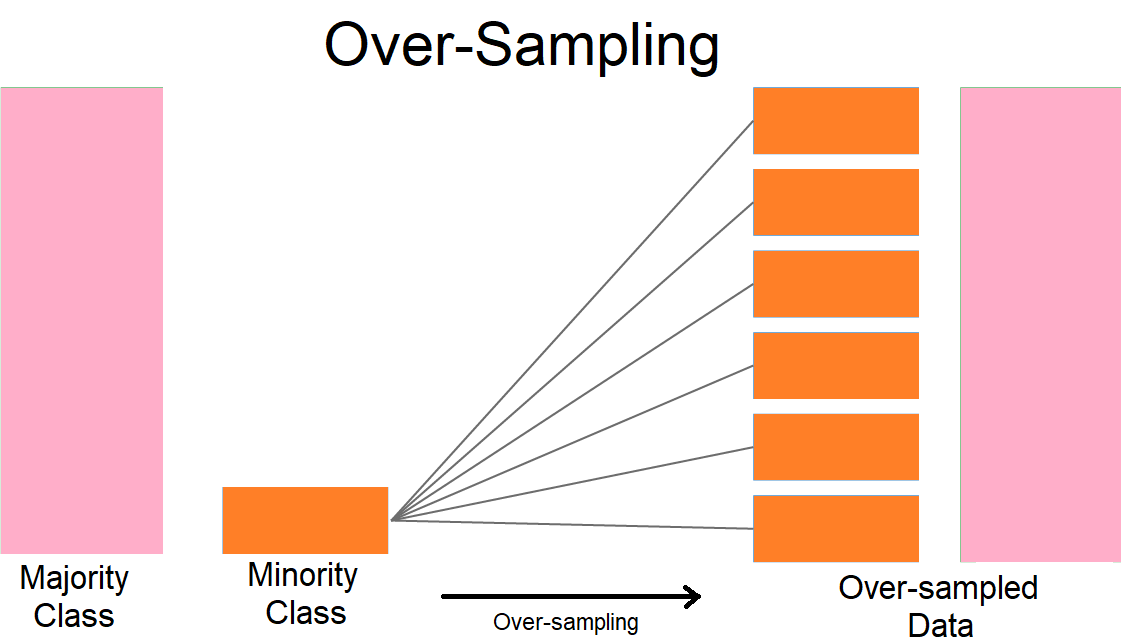

We will be using SMOTE for over-sampling purpose. It works by selecting minority samples that are close in the feature space, drawing a line between these samples in the feature space and drawing a new sample at a point along that line.

Specifically, a random sample from the minority class is first chosen. Then k of the nearest neighbors for that sample are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

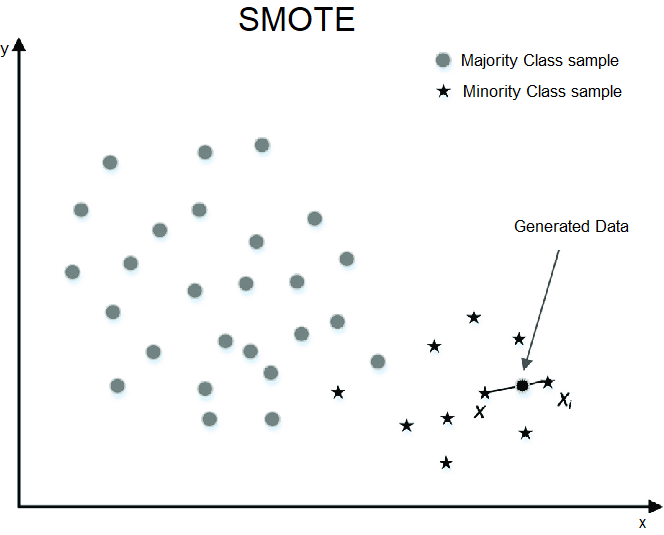

In [ ]:
# Import Synthetic minority over-sampling from imblearn libraray

from imblearn.over_sampling import SMOTE

In [ ]:
smte = SMOTE()
X_os, y_os = smte.fit_resample(X_train,y_train)  # Fit SMOTE with training data and re-sample the data to get balanced data.

In [ ]:
print('Training data          0\'s   1\'s')
print('Before over-sampling  {}   {}'.format(y_train.value_counts()[0],y_train.value_counts()[1]))
print('After over-sampling   {}   {}\n'.format(y_os.value_counts()[0],y_os.value_counts()[1]))

print('After Over-sampling {} synthetic records were added to the training data and now there are equal proportion of 0\'s and 1\'s in the training data'.format(len(X_os)-len(X_train)))

In [ ]:
# Initialize the model
dt_cv = DecisionTreeClassifier(max_depth=10,random_state = 42)

# Lets perform Cross-validation on each of then with 5 fold and find mean f1 score
print('Cross Validation Accuracy')

# Cross Validation on DecisionTreesClassifier
cv_dt = cross_val_score(dt_cv, X_os, y_os, cv = 5, scoring = 'accuracy').mean()
print('For Decision Trees Classifier :', round(cv_dt,3))

In [ ]:
# Cross Validation on DecisionTreesClassifier
cv_dt = cross_val_score(dt_cv, X_test, y_test, cv = 5, scoring = 'accuracy').mean()
print('For Decision Trees Classifier :', round(cv_dt,3))

- After over-smapling, the performance of DecisionTree model increased.

### Hyper-parameter Tuning using GridSearchCV
Let's perform hyper-parameter tuning.  

Grid search is the process of performing hyper-parameter tuning in order to determine the best set of hyper-parameters for a given model. The performance of a model significantly depends on the value of hyperparameters. There is no way to know the best values for hyperparameters. So, we need to try all possible values to know the optimal/best hyperparameters. Doing this manually could take a considerable amount of time and resources and thus we use GridSearchCV to automate this process.  

In GridSearch, we pass range of values for each hyperparameters to the GridSearchCV function. We do this by defining a dictionary in which we mention a particular hyperparameter along with the values it can take in a list.

GridSearchCV tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method. Hence after using this function we get accuracy/loss for every combination of hyperparameters and we can choose the one with the best performance.

GridSearchCV is a function that comes in Scikit-learn’s(or SK-learn) model_selection package

**Import Grid searchCV for hyper-parameter tuning.**

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
# Hyper-parameter Tuning

# Define Parameter's grid
grid = {'max_features': ['log2', 'sqrt','auto'],
              'splitter':['best', 'random'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [20,25,30,35,40], 
              'min_samples_split': [4, 6, 10,15,20],
              'min_samples_leaf': [1, 5, 8]
             }

# Initialize GridSearch
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state = 42), grid, n_jobs=-1, verbose=2,scoring='accuracy',return_train_score=True)

# Perform/train Grid-search
gs_dt.fit(X_os, y_os)

print('Best Parameters :',gs_dt.best_params_)
print('Mean Train Score :',round(gs_dt.cv_results_['mean_train_score'].mean(),4))
print('Mean Test Score :',round(gs_dt.cv_results_['mean_test_score'].mean(),4))
print('Best Test  Score :',round(gs_dt.best_score_,4))

- After Hyper-parameter tuning, the performance is slightly improved.
- Also, there is slight difference in the train and test score which means our model has not over-fitted.

#### Define Best Model using the hyper-parameters obatained after tuning

In [ ]:
dt = DecisionTreeClassifier(criterion= 'entropy', splitter= 'best', max_depth= 25, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 4,random_state = 42)

#### Train the best model and make prediction for the testing data

In [ ]:
y_pred = dt.fit(X_os,y_os).predict(X_test)

#### Lets Visualize the Trained Decision Tree using plot_tree

In [ ]:
from sklearn import tree
# Initialize Figure
plt.figure(figsize=(120,110))

# Plot Decision tree
tree.plot_tree(dt, filled=True)
plt.show()

## 6. Model Evaluation

Import Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

 - **Confusion matrix** : A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand
 - **Accuracy** : Out of total records in test data, how many did you classify correctly?
 - **Precisoin** : Whenever you classify a record as positive, what is the % chance that you are right?
 - **Recall** : Out of all the records of a particular class, how many did you classify correctly?
 - **F1-score** : Harmonic mean of Precision and Recall.

In [ ]:
print('Accuracy  score : ' + str(round(accuracy_score(y_test,y_pred),3)))


print('Precision score : ' + str(round(precision_score(y_test,y_pred),3)))
print('Recall    score : ' + str(round(recall_score(y_test,y_pred),3)))
print('F1        score : ' + str(round(f1_score(y_test,y_pred),3)))

print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, y_pred)))

The Model performed extremely well. Value of All the performance Metric's were greater than 85%

#### Lets plot ROC Curve  
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters which are True Positive Rate and False Positive Rate.  
The True Positive Rate(TPR) of a model should be high and False Positive Rate(FPR) should be low. Also the Area under the curve (AUC) should be high. The maximum value of AUC is 1.

In [ ]:
# Import auc, roc_curve
from sklearn.metrics import auc, roc_curve

# Get false positive rate, true positive rate and threshold
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# Compute Area under curve
area = auc(fpr, tpr)

# plot the roc curve
# Initialize Figure
plt.figure(figsize=(18,5))

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)

# plot straight line
plt.plot([0, 1], [0, 1],color='g', marker='_')

# set plot title, xlabel, ylabel, legend
plt.title('ROC Curve', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.legend(loc = 'lower right', fontsize = 12)

plt.show()

Area under curve value 0.97 which means our model has good prediction performance.

#### Let's check the Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. It basically consists of 4 types of performance metrics discussed earlier i.e. accuracy, precision, recall, f1 scroe.

In [ ]:
from sklearn.metrics import classification_report

print('Classification Report\n',classification_report(y_test, y_pred))

The developed model properly classified both of the classes of target variable. Even for the minority class (1's or employee Attrition), the f1 score was 0.96. It means that our model has learned to predict the employee Attrition very well.

## Notes
- The performance of the developed model is excellent, and it can be deployed to predict future Employee Attrition.
- We found a lot of insights about Employee Attrition during EDA.
- Few major cause of Employee Attrition includes Human Resource work, bad work-life balance, Frequent Travels and Unmarried Employees. So, in order to reduce attrition, Company should mainly focus on these reasons.
- Over-sampling significantly improved the performance of non-tree based models(Logistic Regression and KNN).
- The final model performance was superb. But it can still be enhanced using other advanced models and techniques like model stacking etc.